In [15]:
import preprocessing
import bl
import numpy as np
import calc_weights
import pandas as pd
import efficient_frontier


# Data Preparation
Market capitalization: Scrapped from yahoo finance \
Excessive return: Calculated from yahoo finance historical data--Adjusted Close (Use one year data from 2023-07-10 to 2024-07-05). Included eight stocks: 'MSFT','NVDA','AAPL','AMZN','META','GOOG','AVGO','LLY'. Used S&P500 as the market return.\
Cov: Calculated the covariance matrix from Excessive return

In [2]:
df_marketcap = preprocessing.market_cap_df()
df_ret = preprocessing.exreturn_adclose_df()
cov = np.array(preprocessing.get_cov_matrix(df_ret))


In [4]:
# market cap measured in T (trillion)
df_marketcap

,names,market_cap
0,MSFT,3.180000
1,NVDA,2.959000
2,AAPL,3.134000
3,AMZN,1.947000
4,META,1.270000
5,GOOG,2.159000
6,AVGO,0.667544
7,LLY,0.817348


In [5]:
df_ret.head()

,MSFT,NVDA,AAPL,AMZN,META,GOOG,AVGO,LLY
Date,,,,,,,,
2023-07-10,-0.015984,-0.007599,-0.010856,-0.020419,0.012288,-0.027218,0.036587,0.002389
2023-07-11,0.001929,0.005334,-0.002810,0.012979,0.014247,0.007187,0.004922,-0.030387
2023-07-12,0.014227,0.035302,0.008985,0.015686,0.037044,0.016226,0.008956,0.002754
2023-07-13,0.016192,0.047264,0.004057,0.026758,0.013157,0.043555,0.000461,-0.013391
2023-07-14,0.007529,-0.011049,0.000787,0.002829,-0.014486,0.006969,-0.001999,0.033954


# Calculate market implied return
market implied return is calculated by 
$$
\Pi = \lambda \Sigma w_{mkt}
$$
where $\lambda$ is the risk aversion coefficient $\frac{mean(R_{market})-R_{riskfree}}{Var(R_{market})}$, 
$\Sigma$ is the Covariance Matrix, and 
$w_{mkt}$ is the weight by market capitalization



In [10]:
delta = preprocessing.get_delta(risk_free_rate=0.03)
market_implied_exreturn = bl.market_implied_exreturn(delta,df_marketcap,cov)
market_implied_return = bl.get_market_implied_return(market_implied_exreturn, risk_free_rate=0.03)
market_implied_return

[*********************100%%**********************]  1 of 1 completed


array([0.03212916, 0.0350488 , 0.0317589 , 0.03281159, 0.03338071,
       0.03247809, 0.03326951, 0.03117963])

# Incorporate Investor's Prediction
In Black-Litterman Model, investor's prediction can be incorporated by providing two matrices P and Q. For example, if I predict stock A will have -0.002 return,stock B will have 0.03 return, and stock C will have 0.01 higher return than stock D, the prediction can be written as:
$$
P = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & -1
\end{pmatrix}
$$

$$
Q = \begin{pmatrix}
-0.002 \\
0.03 \\
0.01
\end{pmatrix}
$$

If some of the stocks in the portfolio don't have a prediction, just add zeros to its corresponding position in P.

In [11]:
# generate two samples of P and Q. By default, P is the identity matrix of length n (# of stocks in portfolio)
# Q is generated by random.normal(0,0.002,8) to represent investor's prediction of return. In real world, it's usually generated by some prediction models.
P, Q = bl.sample_prediction(seed = 10)
P, Q

(array([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]]),
 array([ 2.66317301e-03,  1.43055795e-03, -3.09080058e-03, -1.67676999e-05,
         1.24267195e-03, -1.44017112e-03,  5.31023171e-04,  2.17097051e-04]))

# Representing confidence in prediction
The model use $\Omega$ to represents the variance of prediction. It's related to the confidence level of investor's prediction. We can either calculate $\Omega$ by $\tau p_{k}\Sigma p_{k}^T$, or when specified investor's confidence level, by $\tau\alpha p_{k}\Sigma p_{k}^T$, where $\alpha = \frac{1-conf}{conf}$.

In [12]:
tau = 0.025
# omega = bl.get_default_omega(tau,P,np.array(cov))
omega = bl.get_user_omega([0.8,0.8,0.9,0.8,0.7,0.8,0.8,0.9],tau,P,cov)
print(omega)

[[1.01182089e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.11191539e-06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.43155868e-07 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.93481478e-06
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.55786346e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.89391075e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.52364289e-06 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 9.74105120e-07]]

# Calculate Expected Return by Black-Litterman Model
The formula for expected Return is:
$$

E[R] = \left[ (\tau \Sigma)^{-1} + P' \Omega^{-1} P \right]^{-1} \left[ (\tau \Sigma)^{-1} \Pi + P' \Omega^{-1} Q \right]

$$

In [13]:
bl_ret = bl.calculate_bl_returns(tau,cov,P,omega,market_implied_return,Q)
print(bl_ret)


[0.03251104 0.03770689 0.00905116 0.0320644  0.03467003 0.02316228
 0.03140775 0.03441172]


# Calculate Max Sharpe Ratio Weight and Efficient Frontier of the Portfolio


In [14]:
optimal_weights, sharpe_rt = calc_weights.weights_max_sharpe(bl_ret,np.array(cov))

print("Optimal Weights:", optimal_weights)
print("Maximum Sharpe Ratio:", sharpe_rt)

Optimal Weights: [1.72840664e-01 2.70723203e-01 3.39802513e-16 1.54505586e-16
 1.45524477e-01 1.12906104e-16 0.00000000e+00 4.10911656e-01]
Maximum Sharpe Ratio: 0.33617260101327556


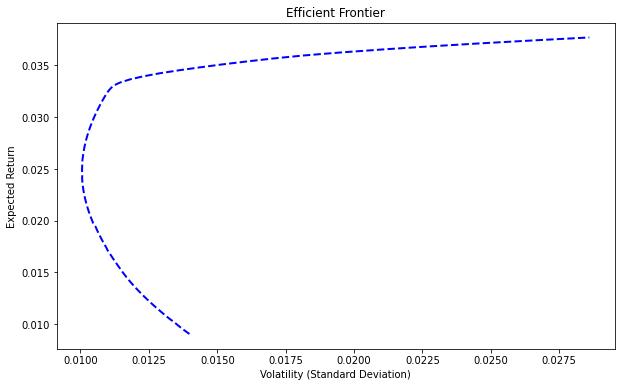

In [16]:
efficient_frontier.plot_efficient_frontier(bl_ret,cov)